### Explorando dados disponíveis no Lab acerca da segmentação de imagens de rochas Carbonáticas em Scans de MicroCT

#### ao todo temos 5 pares (input, label) disponíveis

`usaremos técnicas de data augmentation para elevar nosso número de samples`


vamos importar algumas imagens .tif para este notebook primeiro

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

In [2]:
# Open the .tif image
image = Image.open(r'C:\Users\USER\Desktop\jupytervscode\LabMems\o-net\lab-data\input\1.png')

# Convert the image to a tensor
transform = transforms.ToTensor()
image_tensor = transform(image)

print(image_tensor.shape)

image.show()


torch.Size([3, 3068, 1732])


In [3]:
print("Image shape:", image_tensor.shape)
print("Data type:", image_tensor.dtype)

# Print min and max pixel values
print("Min pixel value:", image_tensor.min())
print("Max pixel value:", image_tensor.max())
print("Mean pixel value:", image_tensor.mean())

Image shape: torch.Size([3, 3068, 1732])
Data type: torch.float32
Min pixel value: tensor(0.2118)
Max pixel value: tensor(0.9725)
Mean pixel value: tensor(0.6578)


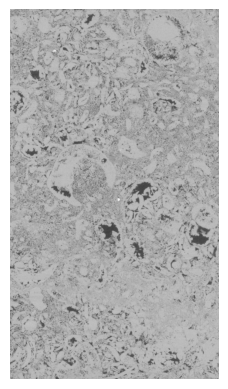

In [4]:
image_numpy = np.array(image_tensor.permute(1, 2, 0))

plt.imshow(image_numpy, cmap='gray')
plt.axis('off')
plt.show()

#### TODO:

- Formatar imagens para: 3060 x 1728

as mini-imagens serão 180x128 resultando em 918 imagens (sem data augmentation)

- criar função: `flip_mirror_flip_and_mirror()` --> performa data augmentation
-  dividir as imagens

depois de data agumentation teremos 3672 imagens por imagem, multiplicando isso por 5: 18360, provavelmente o suficiente para uma baseline da rede neural

In [5]:
# reshape imagens do MicroCT

for filename in os.listdir(r'C:\Users\USER\Desktop\jupytervscode\LabMems\o-net\lab-data\input'):
    file_path = os.path.join(r'C:\Users\USER\Desktop\jupytervscode\LabMems\o-net\lab-data\input', filename)

    image = Image.open(file_path)
    resized = image.resize((1728, 3060))
    new_path = os.path.join(r'C:\Users\USER\Desktop\jupytervscode\LabMems\o-net\lab-data\reshaped\input', filename)
    resized.save(new_path)


# reshape mascaras

for filename in os.listdir(r'C:\Users\USER\Desktop\jupytervscode\LabMems\o-net\lab-data\label'):
    file_path = os.path.join(r'C:\Users\USER\Desktop\jupytervscode\LabMems\o-net\lab-data\label', filename)

    image = Image.open(file_path)
    resized = image.resize((1728, 3060))
    new_path = os.path.join(r'C:\Users\USER\Desktop\jupytervscode\LabMems\o-net\lab-data\reshaped\label', filename)
    resized.save(new_path)

In [7]:
# criar função de data augmentation

def flip_mirror_flip_and_mirror(path1: str, path2: str):
    '''
    Performa data augmentation fazendo, para cada imagem existente, as 4 operações:

    salva a imagem e mascara original
    salva a imagem e mascara espelhadas
    salva a imagem e mascara de cabeça pra baixo
    salva a imagem e mascara espelhadas de cabeça pra baixo

    ou seja, um dataset com x imagens vira um dataset com 4x imagens
    '''
    
    # create path lists for path 1 and 2
    path1_list = []
    for file in os.listdir(path1):
        path1_list.append(os.path.join(path1, file))
    path2_list = []
    for file in os.listdir(path2):
        path2_list.append(os.path.join(path2, file))

    name = 1
    for file_index in range(len(os.listdir(path1))):
        image_path = path1_list[file_index]
        mask_path = path2_list[file_index]

        # save regular image and regular mask
        regular_image = Image.open(image_path)
        regular_image.save(os.path.join(r'C:\Users\USER\Desktop\jupytervscode\LabMems\o-net\lab-data\augmented\input', str(name) + '.png'))
        regular_mask = Image.open(mask_path)
        regular_mask.save(os.path.join(r'C:\Users\USER\Desktop\jupytervscode\LabMems\o-net\lab-data\augmented\label', str(name) + '.png'))
        name += 1

        # save mirror image and mirror mask
        mirror_image = regular_image.transpose(Image.FLIP_LEFT_RIGHT)
        mirror_image.save(os.path.join(r'C:\Users\USER\Desktop\jupytervscode\LabMems\o-net\lab-data\augmented\input', str(name) + '.png'))
        mirror_mask = regular_mask.transpose(Image.FLIP_LEFT_RIGHT)
        mirror_mask.save(os.path.join(r'C:\Users\USER\Desktop\jupytervscode\LabMems\o-net\lab-data\augmented\label', str(name) + '.png'))
        name += 1

        # save flipped image and flipped mask
        flip_image = regular_image.transpose(Image.FLIP_TOP_BOTTOM)
        flip_image.save(os.path.join(r'C:\Users\USER\Desktop\jupytervscode\LabMems\o-net\lab-data\augmented\input', str(name) + '.png'))
        flip_mask = regular_mask.transpose(Image.FLIP_TOP_BOTTOM)
        flip_mask.save(os.path.join(r'C:\Users\USER\Desktop\jupytervscode\LabMems\o-net\lab-data\augmented\label', str(name) + '.png'))
        name += 1

        # save flipped and mirror image and mask
        flip_and_mirror_image = mirror_image.transpose(Image.FLIP_TOP_BOTTOM)
        flip_and_mirror_image.save(os.path.join(r'C:\Users\USER\Desktop\jupytervscode\LabMems\o-net\lab-data\augmented\input', str(name) + '.png'))
        flip_and_mirror_mask = mirror_mask.transpose(Image.FLIP_TOP_BOTTOM)
        flip_and_mirror_mask.save(os.path.join(r'C:\Users\USER\Desktop\jupytervscode\LabMems\o-net\lab-data\augmented\label', str(name) + '.png'))
        name += 1


In [8]:
flip_mirror_flip_and_mirror(r'C:\Users\USER\Desktop\jupytervscode\LabMems\o-net\lab-data\reshaped\input', r'C:\Users\USER\Desktop\jupytervscode\LabMems\o-net\lab-data\reshaped\label')

In [26]:
# fazer função split

# o objetivo é para cada imagem no path augmented, realizar a divisão dela em mini-imagens de 90x64 assim fazendo com que cada imagem vire 918 imagens

tile_number = 1
for image_name in os.listdir(r'C:\Users\USER\Desktop\jupytervscode\LabMems\o-net\lab-data\augmented\input'):
    image_path = os.path.join(r'C:\Users\USER\Desktop\jupytervscode\LabMems\o-net\lab-data\augmented\input', image_name)
    img = Image.open(image_path)

    # Dimensions of the original image
    img_width, img_height = img.size

    # Dimensions of the patches
    tile_width = 128
    tile_height = 176

    # Calculate the number of pathes along width and height
    cols = img_width // tile_width
    rows = img_height // tile_height

    # Split the image into smaller tiles
    for i in range(rows):
        for j in range(cols):
            # Calculate the bounding box for the current tile
            left = j * tile_width
            upper = i * tile_height
            right = (j + 1) * tile_width
            lower = (i + 1) * tile_height

            # Crop the tile from the original image
            tile = img.crop((left, upper, right, lower))

            # Save the tile with a unique name
            tile.save(os.path.join(r'C:\Users\USER\Desktop\jupytervscode\LabMems\o-net\lab-data\final-data\input', str(tile_number) + '.png'))
            tile_number += 1

print(f"Successfully split the image into {tile_number - 1} tiles.")

tile_number = 1
for image_name in os.listdir(r'C:\Users\USER\Desktop\jupytervscode\LabMems\o-net\lab-data\augmented\label'):
    image_path = os.path.join(r'C:\Users\USER\Desktop\jupytervscode\LabMems\o-net\lab-data\augmented\label', image_name)
    img = Image.open(image_path)

    # Dimensions of the original image
    img_width, img_height = img.size

    # Dimensions of the patches
    tile_width = 128
    tile_height = 176

    # Calculate the number of pathes along width and height
    cols = img_width // tile_width
    rows = img_height // tile_height

    # Split the image into smaller tiles
    for i in range(rows):
        for j in range(cols):
            # Calculate the bounding box for the current tile
            left = j * tile_width
            upper = i * tile_height
            right = (j + 1) * tile_width
            lower = (i + 1) * tile_height

            # Crop the tile from the original image
            tile = img.crop((left, upper, right, lower))

            # Save the tile with a unique name
            tile.save(os.path.join(r'C:\Users\USER\Desktop\jupytervscode\LabMems\o-net\lab-data\final-data\label', str(tile_number) + '.png'))
            tile_number += 1

print(f"Successfully split the image into {tile_number - 1} tiles.")



Successfully split the image into 4420 tiles.
Successfully split the image into 4420 tiles.


### Create UNET (BaseLine)


**architecture characteristics**

- Encoder-size: 4
- Decoder-Size: 4
- Bottleneck: 1

**input-output parameters**

- image in resolution: [1, 176, 128]
- image out resolution: [1, 176, 128]

**hyperparameters**

- kernel-size (convolution): 3x3
- kernel-size (pooling): 2x2

- stride: 1
- padding: 1

**extra calculations:**

- SelfAttention: **False**
- Dilated-Convolution: **False**
- Double-Convolutions: **True**
- Batch-Norm: **True**



In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        
        # define double convolution operation
        self.operation = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.operation(x)

In [4]:
class UNET_Baseline(nn.Module):
    def __init__(self):
        super(UNET_Baseline, self).__init__()

        # input: [1, 180, 128]

        # encoder
        self.encoder1 = DoubleConv(in_channels=1, out_channels=4)
        self.encoder2 = DoubleConv(in_channels=4, out_channels=16) 
        self.encoder3 = DoubleConv(in_channels=16, out_channels=64)
        self.encoder4 = DoubleConv(in_channels=64, out_channels=512)

        # bottleneck
        self.bottom_conv = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bottom_normalizer = nn.BatchNorm2d(num_features=512)
        self.unity_conv = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=1, padding=0)
        
        # decoder
        self.transpose3 = nn.ConvTranspose2d(in_channels=512, out_channels=64, kernel_size=2, stride=2, padding=0, output_padding=0)
        self.decoder3 = DoubleConv(in_channels=128, out_channels=64)

        self.transpose2 = nn.ConvTranspose2d(in_channels=64, out_channels=16, kernel_size=2, stride=2, padding=0, output_padding=0)
        self.decoder2 = DoubleConv(in_channels=32, out_channels=16)

        self.transpose1 = nn.ConvTranspose2d(in_channels=16, out_channels=4, kernel_size=2, stride=2, padding=0, output_padding=0)
        self.decoder1 = DoubleConv(in_channels=8, out_channels=4)

        self.final_conv = nn.Conv2d(in_channels=4, out_channels=1, kernel_size=1)


        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        
        # encoder
        enc1 = self.encoder1(x) # [4, 176, 128]
        enc2 = self.encoder2(self.pool(enc1)) # [16, 88, 64]
        enc3 = self.encoder3(self.pool(enc2)) # [64, 44, 32]
        enc4 = self.encoder4(self.pool(enc3)) # [512, 22, 16]


        # bottleneck
        bottom1 = self.relu(self.bottom_normalizer(self.bottom_conv(enc4)))
        bottom2 = self.relu(self.bottom_normalizer(self.unity_conv(bottom1)))

        # decoder
        dec1 = self.decoder3(torch.cat([self.transpose3(bottom2), enc3], dim=1))
        dec2 = self.decoder2(torch.cat([self.transpose2(dec1), enc2], dim=1))
        dec1 = self.decoder1(torch.cat([self.transpose1(dec2), enc1], dim=1))

        final = self.final_conv(dec1)

        return final

In [5]:
test_model = UNET_Baseline()

x = torch.randn(1, 1, 176, 128)

test_model(x).shape


torch.Size([1, 1, 176, 128])

#### Build Dataset and DataLoader from data

In [5]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

In [6]:
class LabMemsDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_transform=None, mask_transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_transform = img_transform
        self.mask_transform = mask_transform

        self.images = os.listdir(img_dir)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name) # corresponding images and masks have same name

        image = Image.open(img_path).convert("L") # "L" is for grayscale images (1 channel)
        mask = Image.open(mask_path).convert("L")

        if self.img_transform:
            image = self.img_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        
        return image, mask

In [7]:
# initialize transforms

image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.442, std=0.225)
])

mask_transform = transforms.Compose([
    transforms.ToTensor()
])

In [8]:
train_image_dir = r'C:\Users\USER\Desktop\jupytervscode\LabMems\o-net\lab-data\final-data\input'
train_mask_dir = r'C:\Users\USER\Desktop\jupytervscode\LabMems\o-net\lab-data\final-data\label'

test_image_dir = r'C:\Users\USER\Desktop\jupytervscode\LabMems\o-net\lab-data\final-data\test-data\input'
test_mask_dir = r'C:\Users\USER\Desktop\jupytervscode\LabMems\o-net\lab-data\final-data\test-data\label'

train_dataset = LabMemsDataset(img_dir=train_image_dir, mask_dir=train_mask_dir, img_transform=image_transform, mask_transform=mask_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = LabMemsDataset(img_dir=test_image_dir, mask_dir=test_mask_dir, img_transform=image_transform, mask_transform=mask_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

In [9]:
print(f"train data: {len(train_dataset)}")
print(f"test data: {len(test_dataset)}")

train data: 4199
test data: 221


#### Train BaseLine U-Net

In [16]:
baseline = UNET_Baseline()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(baseline.parameters(), lr=0.001)

In [17]:
def pixel_accuracy(outputs: torch.Tensor,masks: torch.Tensor):
    predicted_mask = torch.sigmoid(outputs) > 0.5 # apply threshold

    correct_pixels = (predicted_mask == masks).sum().item()
    # total of pixels in a batch of masks
    total_pixels = masks.numel()
    # accuracy = corret / total
    return correct_pixels / total_pixels


In [19]:
# training loop

EPOCHS = 10

print("training phase")
print("-------------------------------------------------")
for epoch in range(EPOCHS):
    print(f"epoch: {epoch + 1}/{EPOCHS}")
    baseline.train()
    running_loss = 0.0
    running_accuracy = 0.0

    for images, masks in train_loader:
        
        # forward pass
        outputs = baseline(images)
        loss = loss_fn(outputs, masks)

        # backprop and optimizantion
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update running loss
        running_loss += loss.item() * images.size(0)

        # calculate accuracy
        accuracy = pixel_accuracy(outputs, masks)
        running_accuracy = accuracy * images.size(0)

    epoch_loss = running_loss / len(train_dataset)
    epoch_accuracy = running_accuracy / len(train_dataset)
    print(f"train loss: {epoch_loss:.4f}")
    print(f"accuracy: {epoch_accuracy:.4f}")
    print("")

training phase
-------------------------------------------------
epoch: 1/10
train loss: 0.2828
accuracy: 0.0014

epoch: 2/10
train loss: 0.2647
accuracy: 0.0014

epoch: 3/10
train loss: 0.2405
accuracy: 0.0014

epoch: 4/10
train loss: 0.2307
accuracy: 0.0014

epoch: 5/10
train loss: 0.2254
accuracy: 0.0014

epoch: 6/10
train loss: 0.2211
accuracy: 0.0015

epoch: 7/10
train loss: 0.2135
accuracy: 0.0014

epoch: 8/10
train loss: 0.2114
accuracy: 0.0015

epoch: 9/10
train loss: 0.2099
accuracy: 0.0014

epoch: 10/10
train loss: 0.2073
accuracy: 0.0014



In [20]:
# save model

torch.save(baseline.state_dict(), r'C:\Users\USER\Desktop\jupytervscode\LabMems\o-net\lab-data\model\baseline.pth')

#### Evaluate Results of BaseLine UNET

In [10]:
baseline = UNET_Baseline()

baseline.load_state_dict(torch.load(r'C:\Users\USER\Desktop\jupytervscode\LabMems\o-net\lab-data\model\baseline.pth'))

baseline

UNET_Baseline(
  (encoder1): DoubleConv(
    (operation): Sequential(
      (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (encoder2): DoubleConv(
    (operation): Sequential(
      (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (encoder3): DoubleConv(
    (operation): Sequential(
      (0): Conv

In [12]:
test_list = list(test_loader)

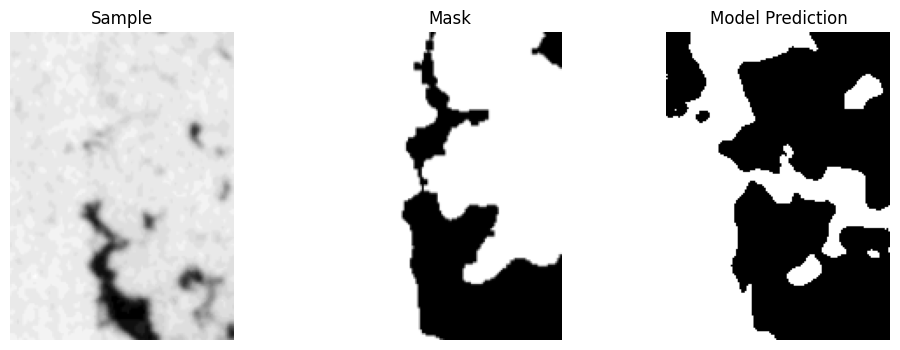

In [18]:
sample, mask = test_list[16]

pred = baseline(sample).detach()

sig = nn.Sigmoid()

pred = sig(pred)

pred = (pred >= 0.5).float()


fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(sample[0].permute(1, 2, 0).numpy(), cmap='gray')
axs[0].set_title('Sample')
axs[0].axis('off')

axs[1].imshow(mask[0].permute(1, 2, 0).numpy(), cmap='gray')
axs[1].set_title('Mask')
axs[1].axis('off')

axs[2].imshow(pred[0].permute(1, 2, 0).numpy(), cmap='gray')
axs[2].set_title('Model Prediction')
axs[2].axis('off')

plt.show()

In [42]:
# salvar todas as mascaras em um folder

from torchvision.transforms import ToPILImage

to_pil = ToPILImage()

i = 1
for img, mask in test_list:
    with torch.inference_mode():
        name = str(i) + '.png'
        pred = to_pil(baseline(img).squeeze().squeeze().clamp(0, 1))
        pred_path = os.path.join(r'C:\Users\USER\Desktop\jupytervscode\LabMems\o-net\lab-data\first-predictions\split-images', name)
        pred.save(pred_path)
        i += 1
        



In [37]:
pred = to_pil(baseline(test_list[0][0]).squeeze().squeeze().clamp(0, 1))

pred.show()

In [19]:
len(test_list)

221

In [43]:
# juntar imagens

# Folder where the tiles are stored
input_folder = r'C:\Users\USER\Desktop\jupytervscode\LabMems\o-net\lab-data\first-predictions\split-images'

# Define tile dimensions (from the previous step)
tile_width = 128
tile_height = 176

# Define the dimensions of the final image (original size)
final_image_width = 1728
final_image_height = 3060

# Calculate the number of columns and rows based on the final image size
cols = final_image_width // tile_width
rows = final_image_height // tile_height

# Create a new blank image to hold the reassembled tiles
final_image = Image.new('L', (final_image_width, final_image_height))

# Loop through the tiles and paste them into the correct position in the final image
tile_number = 1
for i in range(rows):
    for j in range(cols):
        # Construct the path to the current tile
        tile_path = os.path.join(input_folder, str(tile_number) + '.png')
        
        # Open the tile and paste it in the correct position
        tile = Image.open(tile_path)
        left = j * tile_width
        upper = i * tile_height
        final_image.paste(tile, (left, upper))
        
        tile_number += 1

# Save the reassembled image
final_image.save(r'C:\Users\USER\Desktop\jupytervscode\LabMems\o-net\lab-data\first-predictions\full-sample-mask\baseline-pred.png')

print("Successfully reassembled the image!")

# its the sample 9

Successfully reassembled the image!


#### algoritmo para juntar imagens coesamente

In [32]:
def transfer(pred: torch.Tensor, votes: torch.Tensor, i, j):
    '''
    transfere uma matriz de 0 e 1 para um tensor de 2 camadas de profundidade
    '''
    for h in range(176):
        for w in range(128):
            if pred[0, 0, h, w]  >= 0.5:
                # votes[1][i+h][j+w] += 1
                votes[1, i+h, j+w] += 1
            else:
                # votes[0][i+h][j+w] += 1
                votes [0, i+h, j+w] +=1
    return votes

def votes_to_binary(votes):
    '''
    dado um tensor de duas camadas de canal, transforma em uma camada so pegando m maximo de cada canal e assumindo seu index
    '''
    binary = torch.argmax(votes, dim=0, keepdim=True)
    return binary

def predict(path, model):
    img = to_tensor(to_grayscale(Image.open(path)))
    votes = torch.zeros(size=(2, 3060, 1728), dtype=torch.int32)

    for i in range(0, 3060-175):
        for j in range(0, 1728-127):
            print(f"{i * (1728-127)+ j} iteration")
            x = img[:, i:i+176, j:j+128]
            x = x.unsqueeze(dim=0)
            with torch.inference_mode():
                # plt.imshow(np.array(x.squeeze(dim=0).permute(1, 2, 0)), "gray")
                # plt.axis(False)
                # plt.show()
                y = model(x)
                # plt.imshow(np.array(y.squeeze(dim=0).permute(1, 2, 0)), "gray")
                # plt.axis(False)
                # plt.show()
            votes = transfer(y, votes, i, j)
            # plt.imshow(votes_to_binary(votes).permute(1, 2, 0), "gray")
            # plt.axis(False)
            # plt.show()
    print("prediction conversion:")
    prediction = votes_to_binary(votes)
    return prediction
    
image = Image.open(r'C:\Users\USER\Desktop\jupytervscode\LabMems\o-net\lab-data\augmented\input\9.png')

# Convert the image to a tensor
to_grayscale = transforms.Grayscale(num_output_channels=1)
to_tensor = transforms.ToTensor()
image_tensor = to_tensor(to_grayscale(image))
image_tensor.shape



torch.Size([1, 3060, 1728])

In [33]:
pred = predict(r'C:\Users\USER\Desktop\jupytervscode\LabMems\o-net\lab-data\augmented\input\9.png', baseline)

0 iteration
1 iteration
2 iteration
3 iteration
4 iteration
5 iteration
6 iteration
7 iteration
8 iteration
9 iteration
10 iteration


KeyboardInterrupt: 

In [27]:
import pickle

# Assuming you have a dataset instance called `dataset`
with open('test_dataset.pkl', 'wb') as f:
    pickle.dump(test_dataset, f)

In [91]:
a = torch.randn(size=(3, 10, 9))
b = a[3:5][5:9]
b.shape

torch.Size([0, 10, 9])